<a href="https://colab.research.google.com/github/willianrocha/bootcamp-datascience-alura/blob/main/module_1/ds_mod1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Super Desafio: Escolha outro valor fora o valor aprovado no TABNET e explore estes dados. Esse será nosso projeto do módulo, mais detalhes no Desafio do módulo 1 na página do bootcamp.

# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Coleta de dados

Dados
Vou utilizar os dados de vacinação da COVID-19 disponibilizados em https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao/resource/ef3bd0b8-b605-474b-9ae5-c97390c197a8.

Os dados foram extraídos em 23/05/2021. Tem 28.5 GB de tamanho.
Abaixo, apenas as 10 primeiras linhas do documento original.

In [2]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/dados_originais_head.csv" .
pd.read_csv("/content/dados_originais_head.csv", encoding="ISO-8859-1", sep=";").head()

,document_id,paciente_id,paciente_idade,paciente_datanascimento,paciente_enumsexobiologico,paciente_racacor_codigo,paciente_racacor_valor,paciente_endereco_coibgemunicipio,paciente_endereco_copais,paciente_endereco_nmmunicipio,paciente_endereco_nmpais,paciente_endereco_uf,paciente_endereco_cep,paciente_nacionalidade_enumnacionalidade,estabelecimento_valor,estabelecimento_razaosocial,estalecimento_nofantasia,estabelecimento_municipio_codigo,estabelecimento_municipio_nome,estabelecimento_uf,vacina_grupoatendimento_codigo,vacina_grupoatendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_lote,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem,data_importacao_rnds,id_sistema_origem
0,d69492e7-2c28-4892-9aac-0a378206c968-i0b0,7518e34074e7262958c5ca15dddf901de351c253565ee1...,77,1943-09-03,M,1,BRANCA,420480,10,CURITIBANOS,BRASIL,SC,89520,B,2302438,PREFEITURA MUNICIPAL DE CURITIBANOS,POSTO DE ATEND MATERNO INFANTIL,420480,CURITIBANOS,SC,0,NaN,NaN,NaN,210068,SERUM INSTITUTE OF INDIA LTD,NaN,2021-03-20,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,ESUS APS - NACIONAL (OFFLINE),2021-03-24T12:31:25.000Z,NaN
1,00008936-722c-4329-a8f8-49f914c14231-i0b0,fa0290484b076c2b4df18119863be049cf6ebd9690184e...,77,1944-02-21,M,3,PARDA,110020,10,PORTO VELHO,BRASIL,RO,76820,B,213241,MUNICIPIO DE PORTO VELHO,CENTRAL DE REDE DE FRIO PORTO VELHO,110020,PORTO VELHO,RO,204,Pessoas de 75 a 79 anos,2.0,Faixa EtÃ¡ria,210017,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-23,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-23T12:59:53.000Z,NaN
2,5af902c3-caff-4a1a-8c8e-efd78c71fb73-i0b0,8e37fba588e2e90a219427b9a5d9c58127a73eb8b4df90...,75,1945-04-10,M,1,BRANCA,510675,10,PONTES E LACERDA,BRASIL,MT,78250,B,2394456,PREFEITURA MUNICIPAL DE PONTES E LACERDA,CENTRO DE SAUDE DE PONTES E LACERDA,510675,PONTES E LACERDA,MT,301,Pessoas de 60 nos ou mais Institucionalizadas,3.0,Pessoas de 60 anos ou mais institucionalizadas,210086,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-30,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-04-03T13:07:42.000Z,NaN
3,7fa5874c-7bf6-47ba-ab4b-50a95d8ee472-i0b0,11220f7797eb222c83c82fbff09d2af82aebc6ddab6c6b...,90,1930-06-13,F,1,BRANCA,330100,10,CAMPOS DOS GOYTACAZES,BRASIL,RJ,28051,B,6298109,SECRETARIA MUNICIPAL DE SAUDE DE CAMPOS DOS GO...,SECRETARIA MUNICIPAL DE SAUDE DE CAMPOS DOS GO...,330100,CAMPOS DOS GOYTACAZES,RJ,205,Pessoas de 80 anos ou mais,2.0,Faixa EtÃ¡ria,210011A,FUNDACAO BUTANTAN,Organization/61189445000156,2021-02-18,Â Â Â Â 1ÂªÂ Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-17T19:47:19.000Z,NaN
4,5afa5eab-1fd1-4c36-91bf-8b098c5ee3ab-i0b0,af81199ba8994176baeaecbc4a2b7d3ad71d3432b765b2...,64,1957-03-25,F,3,PARDA,280030,10,ARACAJU,BRASIL,SE,49044,B,2550,SECRETARIA MUNICIPAL DE SAUDE DE ARACAJU,US ELIZABETE PITA TERRA DURA,280030,ARACAJU,SE,201,Pessoas de 60 a 64 anos,2.0,Faixa EtÃ¡ria,CTMAV505,FUNDACAO OSWALDO CRUZ,NaN,2021-04-07,Â Â Â Â 1ÂªÂ Dose,85,Vacina Covid-19 - Covishield,IDS SaÃºde,2021-04-07T11:13:09.000Z,NaN


Como a base original contém informações que não serão utilizadas nesta análise, extraí apenas as colunas que serão utilizadas. E realizei um trabalho de eliminar caracteres desnecessários (como aspas duplas) e simplificar informações como a dose aplicada de "Â Â Â Â 1ÂªÂ Dose" para 1 ou 2, de acordo com a dose aplicada.

Resultando em 2.8GB. Este arquivo tem 57.442.714 linhas.

Abaixo, o comando usado localmente para extrair as colunas e limpar os dados.
```
cut part-00000-6bab261e-57eb-41e1-9523-8487c4a7c57c-c000.csv -d ";" -f3,5,7,12,20,26,28,29 | sed 's/"//g' | sed -E 's/    ([12]).*/\1/g' > vaccines_v2.csv
```


## Amostragem

A base de dados ainda está muito grande para ser trabalhada livremente. Então, antes de começar as análises, extraí uma amostra com 20 mil linhas e já deixei preparado em um CSV.

In [3]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/sample20k_v3.csv" .
dados = pd.read_csv("/content/sample20k_v3.csv", encoding="ISO-8859-1", sep=",")
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose
0,77.0,F,AMARELA,SC,SC,FUNDACAO BUTANTAN,2021-04-12,2
1,32.0,F,BRANCA,RN,RN,FUNDACAO BUTANTAN,2021-01-27,1
2,92.0,F,BRANCA,MG,MG,FUNDACAO BUTANTAN,2021-03-06,2
3,67.0,M,SEM INFORMACAO,BA,BA,FUNDACAO BUTANTAN,2021-03-28,1
4,64.0,M,AMARELA,TO,TO,FUNDACAO OSWALDO CRUZ,2021-04-30,1


# Exploração inicial

Exploração inicial para visualizar e entender como estão distribuídos os dados.

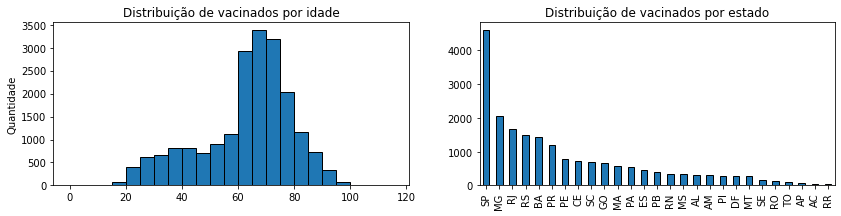

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,3))

# Tem uma pessoa com 221 anos!
ax = dados['paciente_idade'].plot(kind='hist', bins=[x for x in range(0,120,5)],
                             edgecolor='black', ax=axes[0],
                             title="Distribuição de vacinados por idade")
ax.set_ylabel("Quantidade")
dados['estabelecimento_uf'] \
  .value_counts().plot(kind='bar',  ax=axes[1], edgecolor='black',
                       title="Distribuição de vacinados por estado")

plt.show()

In [10]:
dados['vacina_fabricante_nome'].value_counts().head()

FUNDACAO BUTANTAN        8745
FUNDACAO OSWALDO CRUZ    4227
SINOVAC                  1872
ASTRAZENECA/OXFORD       1214
Sinovac                  1075
Name: vacina_fabricante_nome, dtype: int64

Não existe padrão de preenchimento de dados.

Listei todos os valores, montei uma planilha do excel e fui mapeando para os nomes comerciais. Esse mapeamento está no arquivo 'vaccines_normalization.csv'. Essa lista contém os valores apenas para as 20 mil linhas extraídas, quando formos trabalhar no dataset inteiro, vai quebrar :D

In [4]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/vaccines_normalization.csv" .
label_vacinas = pd.read_csv("/content/vaccines_normalization.csv",
                            encoding="ISO-8859-1", sep=",")
label_vacinas = label_vacinas.set_index('label')
label_vacinas = label_vacinas.to_dict()
label_vacinas = label_vacinas['vaccine']
vacinas_normalizada = []
for vc in dados['vacina_fabricante_nome']:
  if type(vc) != float: # NaN no dataframe
    vacinas_normalizada.append(label_vacinas[vc])
  else:
    vacinas_normalizada.append('Unknown')
dados['vacina_fabricante_nome_n'] = vacinas_normalizada
dados['vacina_fabricante_nome_n'].value_counts()

CoronaVac      12448
AstraZeneca     6509
MS               490
Unknown          406
Pfizer           146
Sanofi             1
Name: vacina_fabricante_nome_n, dtype: int64

Dado a não padronização dos nomes da vacina no dataset original, temos nomes de vacinas como MS (aka 'Ministério da Saúde') a qual não sabemos qual é. Um detalhe interessante, é que essa amostra pegou uma vacina ainda em testes, da Sanofi.

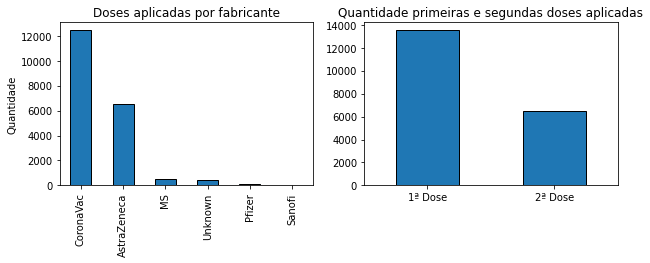

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax = dados['vacina_fabricante_nome_n'] \
  .value_counts().plot(kind='bar', ax=axes[0],
                       title="Doses aplicadas por fabricante", 
                       edgecolor='black')
ax.set_ylabel("Quantidade")
ax = dados['vacina_descricao_dose'] \
  .value_counts().plot(kind='bar', ax=axes[1],
                       title="Quantidade primeiras e segundas doses aplicadas",
                       rot=0, edgecolor='black')

ax.set_xticklabels(["1ª Dose", "2ª Dose"])
plt.show()

Outro problea encontrado é a falta de preenchimento de alguns campos, como "Raça/Cor".

In [13]:
dados['paciente_racacor_valor'].value_counts()

BRANCA            7579
SEM INFORMACAO    5256
PARDA             3641
AMARELA           2530
PRETA              841
INDIGENA           153
Name: paciente_racacor_valor, dtype: int64

O que leva às mulheres a terem 60% de vacinação, enquanto que os homents apenas 40%?

In [14]:
dados['paciente_enumsexobiologico'].value_counts()

F    11828
M     8172
Name: paciente_enumsexobiologico, dtype: int64

## Datas

As datas nos dão uma distribuição no tempo de quantas doses foram aplicadas, porém no formato atual, elas ficam um pouco complicadas de serem trabalhadas. 

Vamos criar uma nova coluna para distribuir por mês.

In [6]:
dados['vacina_dataaplicacao_mes'] = ["-".join(dt.split('-')[:2])
                                     for dt in dados['vacina_dataaplicacao']]
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome_n,vacina_dataaplicacao_mes
0,77.0,F,AMARELA,SC,SC,FUNDACAO BUTANTAN,2021-04-12,2,CoronaVac,2021-04
1,32.0,F,BRANCA,RN,RN,FUNDACAO BUTANTAN,2021-01-27,1,CoronaVac,2021-01
2,92.0,F,BRANCA,MG,MG,FUNDACAO BUTANTAN,2021-03-06,2,CoronaVac,2021-03
3,67.0,M,SEM INFORMACAO,BA,BA,FUNDACAO BUTANTAN,2021-03-28,1,CoronaVac,2021-03
4,64.0,M,AMARELA,TO,TO,FUNDACAO OSWALDO CRUZ,2021-04-30,1,AstraZeneca,2021-04


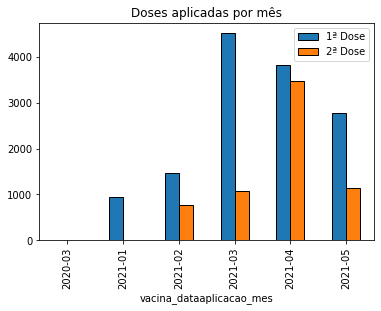

In [7]:
ax = dados.groupby(['vacina_dataaplicacao_mes','vacina_descricao_dose']) \
  .size().unstack().plot(kind='bar', edgecolor='black')
ax.set_title("Doses aplicadas por mês")
ax.legend(["1ª Dose", "2ª Dose"])
plt.show()

Os dados apresentados acima nos dão um bom panorama de quando as vacinas começaram e como estão indo em relação a primeira e segunda dose.

Vamos granuzalizar esses dados por semana.

In [8]:
from datetime import datetime
date_format = '%Y-%m-%d'
dados['vacina_dataaplicacao_semana'] = \
  [datetime.strptime(dt, date_format).isocalendar()[1]
   for dt in dados['vacina_dataaplicacao']]
dados.head()

,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_fabricante_nome_n,vacina_dataaplicacao_mes,vacina_dataaplicacao_semana
0,77.0,F,AMARELA,SC,SC,FUNDACAO BUTANTAN,2021-04-12,2,CoronaVac,2021-04,15
1,32.0,F,BRANCA,RN,RN,FUNDACAO BUTANTAN,2021-01-27,1,CoronaVac,2021-01,4
2,92.0,F,BRANCA,MG,MG,FUNDACAO BUTANTAN,2021-03-06,2,CoronaVac,2021-03,9
3,67.0,M,SEM INFORMACAO,BA,BA,FUNDACAO BUTANTAN,2021-03-28,1,CoronaVac,2021-03,12
4,64.0,M,AMARELA,TO,TO,FUNDACAO OSWALDO CRUZ,2021-04-30,1,AstraZeneca,2021-04,17


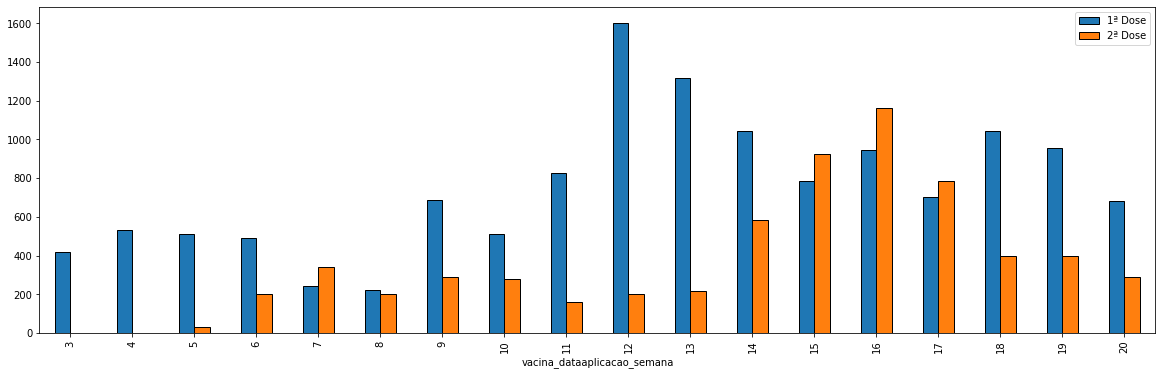

In [9]:
ax = dados.groupby(['vacina_dataaplicacao_semana','vacina_descricao_dose']) \
  .size().unstack().plot(kind='bar', figsize=(20,6), edgecolor='black')
ax.legend(["1ª Dose", "2ª Dose"])
l = ax.get_legend()
plt.show()

Vacinados por idade com gênero sobrepostos

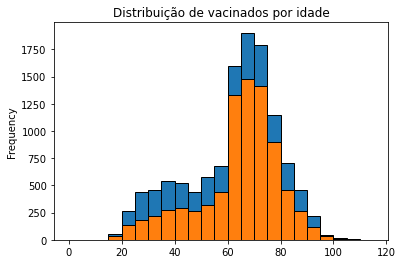

In [10]:
bins_idade = [x for x in range(0,120,5)]
# bins_idade.append(120)
ax = dados.groupby('paciente_enumsexobiologico')['paciente_idade'].plot(kind='hist', bins=bins_idade,
                             edgecolor='black',# orientation='horizontal',
                             title="Distribuição de vacinados por idade")

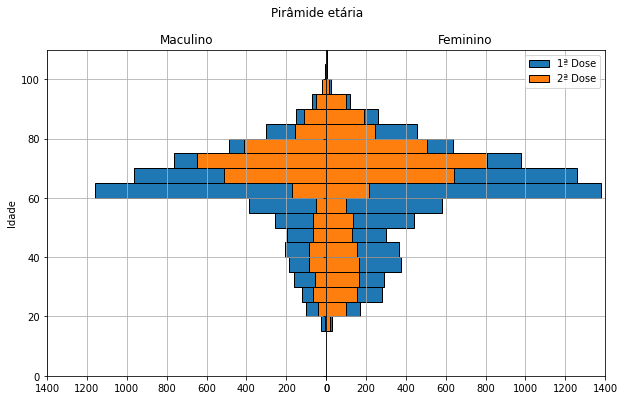

In [11]:
import matplotlib.patches as mpatches

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Pirâmide etária")
plt.subplots_adjust(wspace=0, hspace=0)
y_lim_sup = 110
y_lim_inf = 0
x_lim_sup = 1400
axes[0].set_xlim(0,x_lim_sup)
axes[1].set_xlim(0,x_lim_sup)
axes[0].set_ylim(y_lim_inf,y_lim_sup)
axes[1].set_ylim(y_lim_inf,y_lim_sup)
axes[0].invert_xaxis()

d_bins = {}

for group in dados.groupby(['paciente_enumsexobiologico','vacina_descricao_dose']):
  if group[0][0] is 'M':
    idade_maculina = group[1]['paciente_idade']
    ax = idade_maculina.plot(kind='hist', edgecolor='black', bins=bins_idade,
                             orientation='horizontal', ax=axes[0], grid=True,
                             title="Maculino")
    ax.set_xlabel("")
    ax.set_ylabel("Idade")
  if group[0][0] is 'F': # Genero
    idade_feminina = group[1]['paciente_idade']
    ax = idade_feminina.plot(kind='hist', bins=bins_idade, edgecolor='black',
                             orientation='horizontal', ax=axes[1], grid=True,
                             title="Feminino")
    ax.set_yticklabels([])
    ax.set_xlabel("")
  d_bins[f'{group[0][0]}{str(group[0][1])}'] = [i.get_width() for i in ax.patches]

st_shot = mpatches.Patch(facecolor='#1f76b4', edgecolor='k', label="1ª Dose")
nd_shot = mpatches.Patch(facecolor='#ff7e0e', edgecolor='k', label="2ª Dose")
plt.legend(handles=[st_shot, nd_shot])
plt.show()

Os bins do gráfico anteiror foram reaproveitados no próximo gráfico, porém tiveram que serem trabalhados para se alinharem ao range dos novos dados.

In [13]:
d_bins['F2'] = d_bins['F2'][23:]
d_bins['M2'] = d_bins['M2'][23:]
for k in d_bins:
  first_years = d_bins[k][:20]
  first_years.append(sum(d_bins[k][20:]))
  d_bins[k] = first_years.copy()

Apesar dessa pirâmide etártia já contar algumas informações importantes, como a população feminina estar mais vacinada e a mais quantidade de vacinados em grupos de idade mais alta. Ainda apresenta alguns problemas, como a comparação com a população total.

Dados coletados da pirâmide etária foram adicionados para dar mais um grau de profundidade a vacinação Brasileira.

Fonte: https://www.populationpyramid.net/pt/brasil/2021/

In [14]:
!cp "/content/drive/MyDrive/alura/bootcamp-data-science/population_pyramid_brasil_2021.csv" .
pir_etaria = pd.read_csv("/content/population_pyramid_brasil_2021.csv")
# Arranjo tecnico para que o gráfico fique bonitão, tem 0 validade :D 
pir_etaria['M'] = pir_etaria['M']/1000
pir_etaria['F'] = pir_etaria['F']/1000
df_hist_vac = pd.DataFrame()
df_hist_vac = df_hist_vac.from_dict(d_bins)

In [163]:
df_piramide = pd.concat([pir_etaria, df_hist_vac], axis=1)
# df_piramide = df_piramide.set_index('Age')
df_piramide.head()

,Age,M,F,F1,F2,M1,M2
0,0-4,7357.796,7027.050,0.0,0.0,0.0,0.0
1,5-9,7456.918,7126.488,0.0,0.0,0.0,0.0
2,10-14,7550.011,7244.662,0.0,0.0,0.0,1.0
3,15-19,8110.694,7827.868,31.0,19.0,25.0,6.0
4,20-24,8630.334,8410.568,168.0,99.0,100.0,40.0


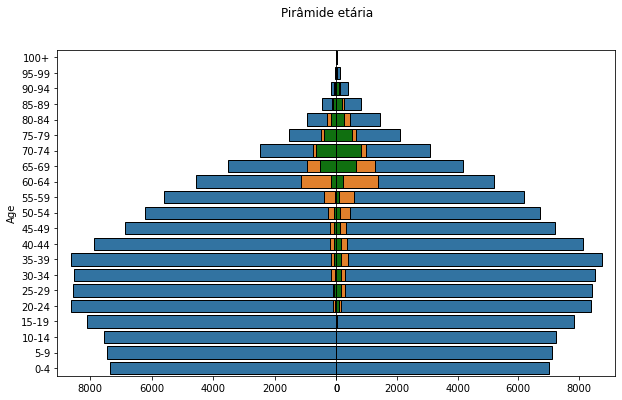

In [196]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Pirâmide etária")
plt.subplots_adjust(wspace=0, hspace=0)
axes[0].invert_xaxis()

sns.barplot(x="M",y="Age", color="#1f76b4", data = df_piramide, ax=axes[0], edgecolor='black')
sns.barplot(x="M1",y="Age", color="#ff7e0e", data = df_piramide, ax=axes[0], edgecolor='black')
sns.barplot(x="M2",y="Age", color="g", data = df_piramide, ax=axes[0], edgecolor='black')

sns.barplot(x="F",y="Age", color="#1f76b4", data = df_piramide, ax=axes[1], edgecolor='black')
sns.barplot(x="F1",y="Age", color="#ff7e0e", data = df_piramide, ax=axes[1], edgecolor='black')
sns.barplot(x="F2",y="Age", color="g", data = df_piramide, ax=axes[1], edgecolor='black')

axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[1].set_yticklabels([])
axes[1].set_ylabel("")
axes[0].set_xlabel("")
axes[1].set_xlabel("")

axes[1].tick_params(left=False)

# Dados completos - WIP

In [3]:
#!cp "/content/drive/MyDrive/alura/bootcamp-data-science/vaccines_v2.csv" .
dados = pd.read_csv("/content/vaccines_v2.csv", encoding="ISO-8859-1", sep=";")
dados.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,paciente_idade,paciente_enumsexobiologico,paciente_racacor_valor,paciente_endereco_uf,estabelecimento_uf,vacina_fabricante_nome,vacina_dataaplicacao,vacina_descricao_dose
0,77.0,M,BRANCA,SC,SC,SERUM INSTITUTE OF INDIA LTD,2021-03-20,1
1,77.0,M,PARDA,RO,RO,FUNDACAO BUTANTAN,2021-03-23,1
2,75.0,M,BRANCA,MT,MT,FUNDACAO BUTANTAN,2021-03-30,1
3,90.0,F,BRANCA,RJ,RJ,FUNDACAO BUTANTAN,2021-02-18,1
4,64.0,F,PARDA,SE,SE,FUNDACAO OSWALDO CRUZ,2021-04-07,1
